<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/32_S%2BP_Week_2_Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None) :
  plt.plot(time[start : end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0) :
  return slope * time

def seasonal_pattern(season_time) :
  return  np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0) :
  season_time = ((time + phase) % period) / period

  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None) :
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 20
slope = 0.09
noise_level = 5

In [4]:
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time :]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

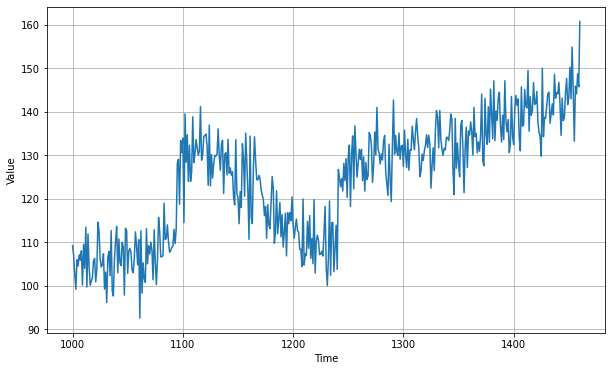

In [5]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder= True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window : (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
model.fit(dataset, epochs = 100, verbose = 0)

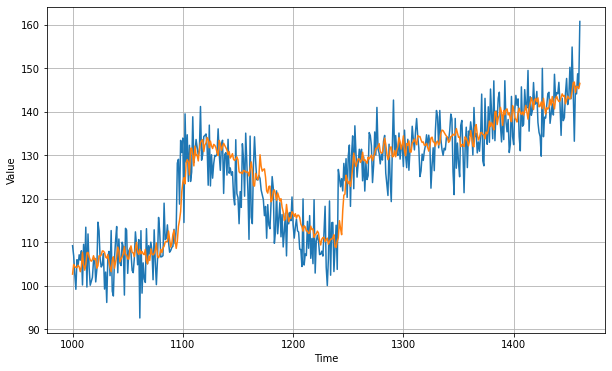

In [8]:
forecast = []

for time in range(len(series) - window_size) :
  forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6269994

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 **(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = 'mse', optimizer = optimizer)
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule], verbose= 0)

(1e-08, 0.001, 0.0, 300.0)

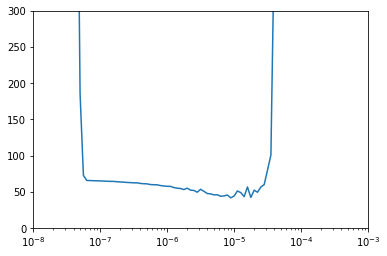

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [19]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape = [window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr = 8e-6, momentum = 0.9)
model.compile(loss = 'mse', optimizer = optimizer)
history = model.fit(dataset, epochs = 500, verbose = 0)

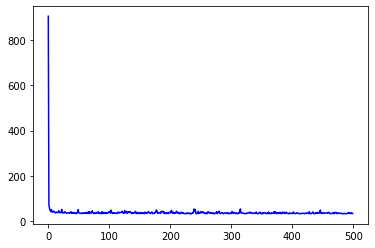

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[38.73823928833008, 38.93770217895508, 37.2752571105957, 40.350830078125, 37.876529693603516, 38.341190338134766, 38.9253044128418, 46.08782196044922, 38.145233154296875, 37.59706115722656, 38.268638610839844, 39.10066604614258, 52.15080642700195, 35.89105987548828, 39.31846237182617, 37.30302429199219, 36.444820404052734, 41.60368728637695, 38.994205474853516, 36.80281066894531, 35.052391052246094, 36.025970458984375, 36.832828521728516, 37.230735778808594, 34.7320556640625, 35.221065521240234, 39.04107666015625, 42.42526626586914, 34.83695602416992, 38.890628814697266, 35.0226936340332, 38.80276107788086, 36.655242919921875, 35.37672805786133, 37.236934661865234, 33.647953033447266, 33.56094741821289, 37.83369064331055, 37.21633529663086, 51.044334411621094, 37.07074737548828, 35.39264678955078, 34.262359619140625, 34.31595993041992, 36.16523361206055, 36.41905212402344, 33.75960159301758, 36.119346618652344, 34.44063949584961, 35.65067672729492, 38.011680603027344, 35.46298217773437

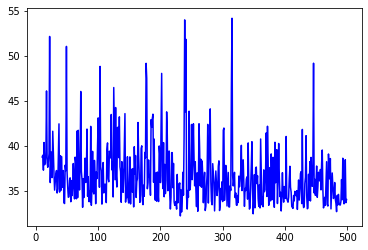

In [21]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

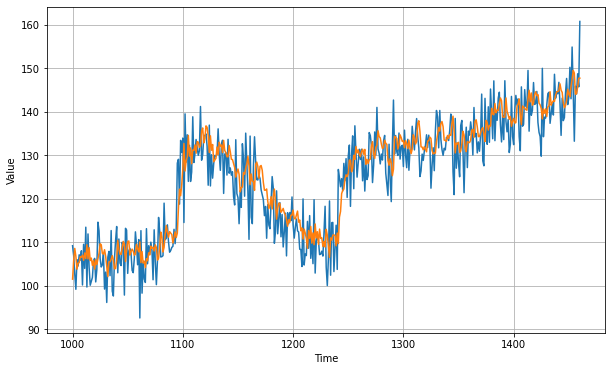

In [22]:
forecast = []

for time in range(len(series) - window_size) :
  forecast.append(model.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7195973